In [29]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

In [30]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [31]:
cleansed=load_amihud_markets_price()

In [32]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [33]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [34]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)

In [35]:
factors=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


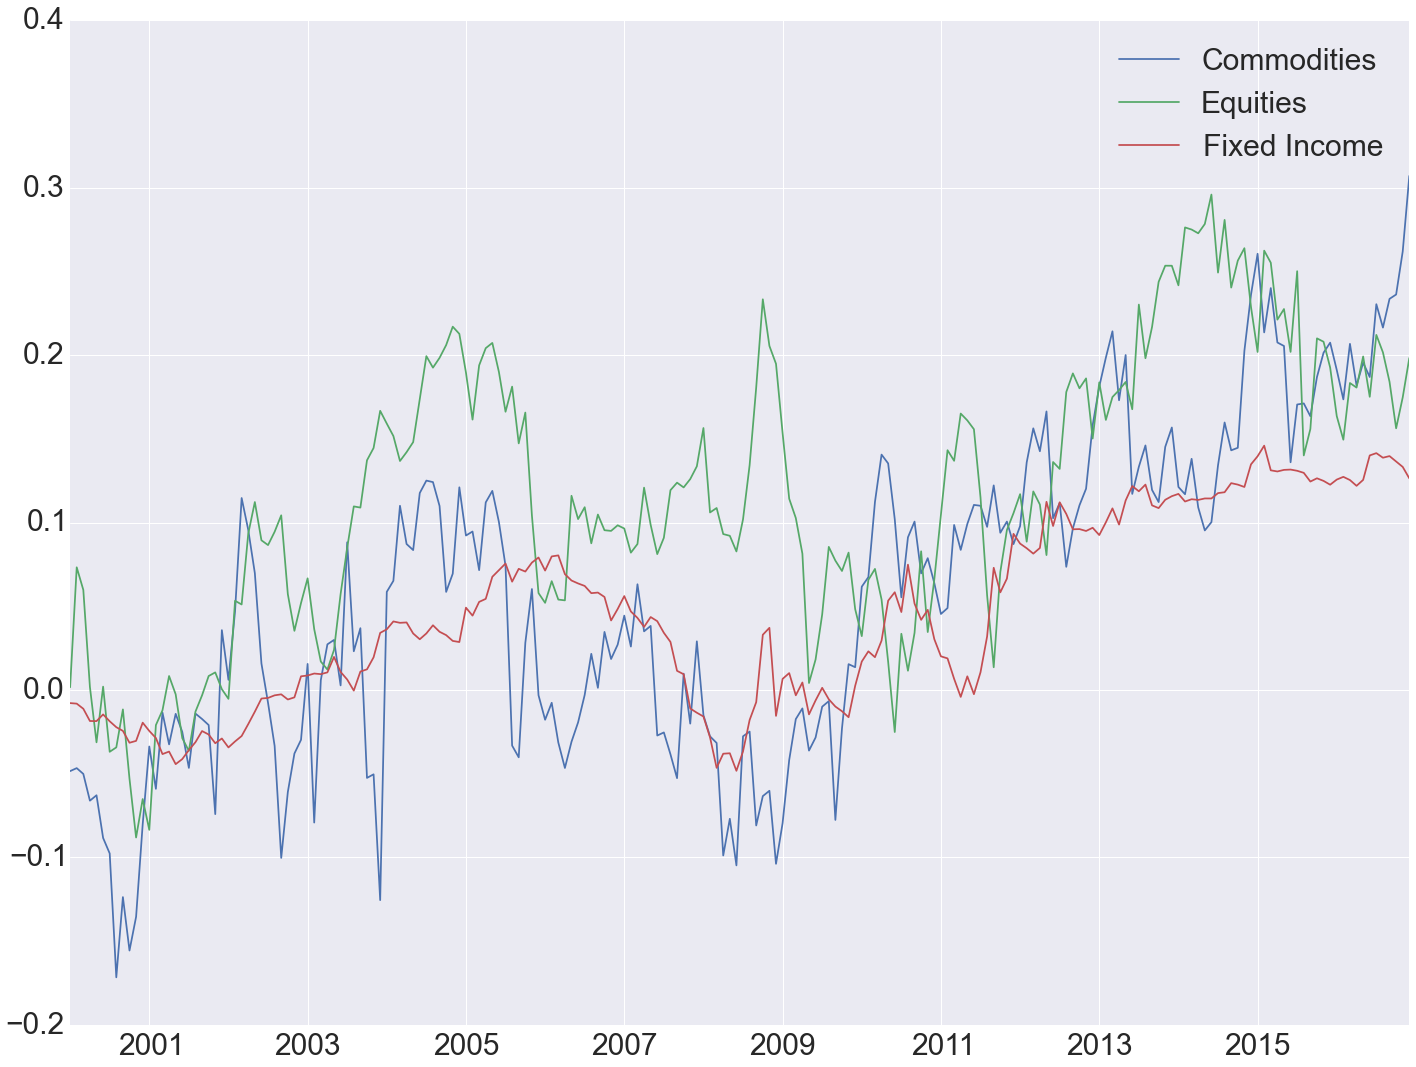

In [36]:
factors.cumsum().plot()

# FHT Annual portfolio sorts

In [37]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [40]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)

In [41]:
factors_FHT=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_FHT[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


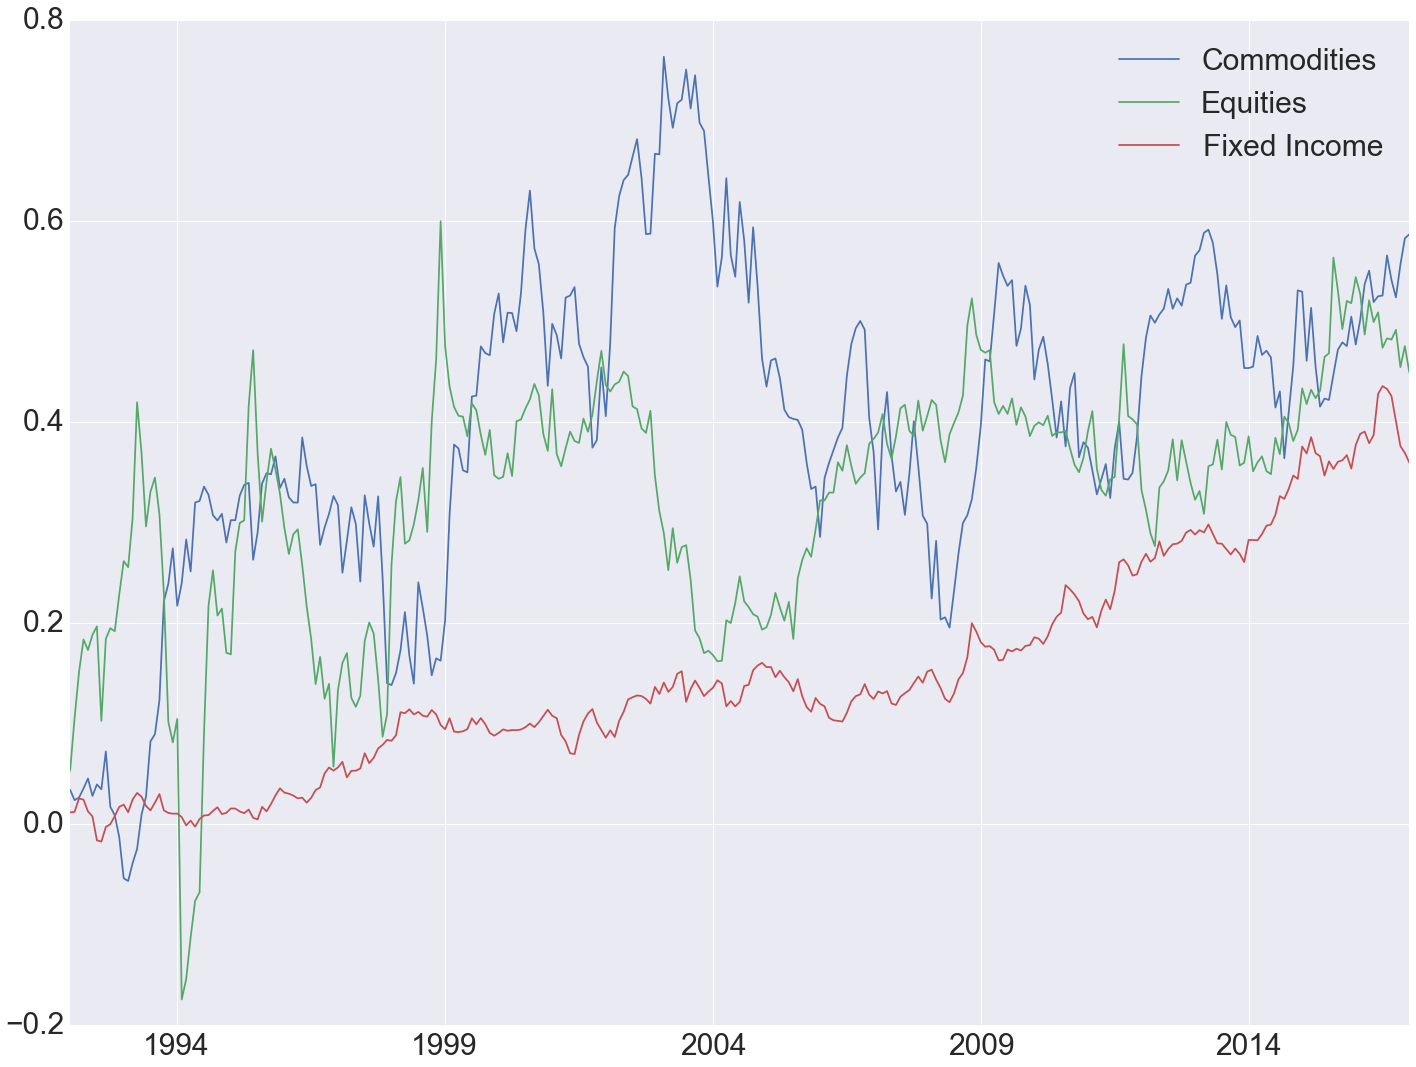

In [42]:
factors_FHT.cumsum().plot()

# Monthly portfolio sorts

# Monthly portoflio sorts

In [43]:
amihud_monthly = read_monthly(amihud=True)

In [44]:
factors_monthly=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_monthly[s]=amihud_monthly[s]['2']-amihud_monthly[s]['0']


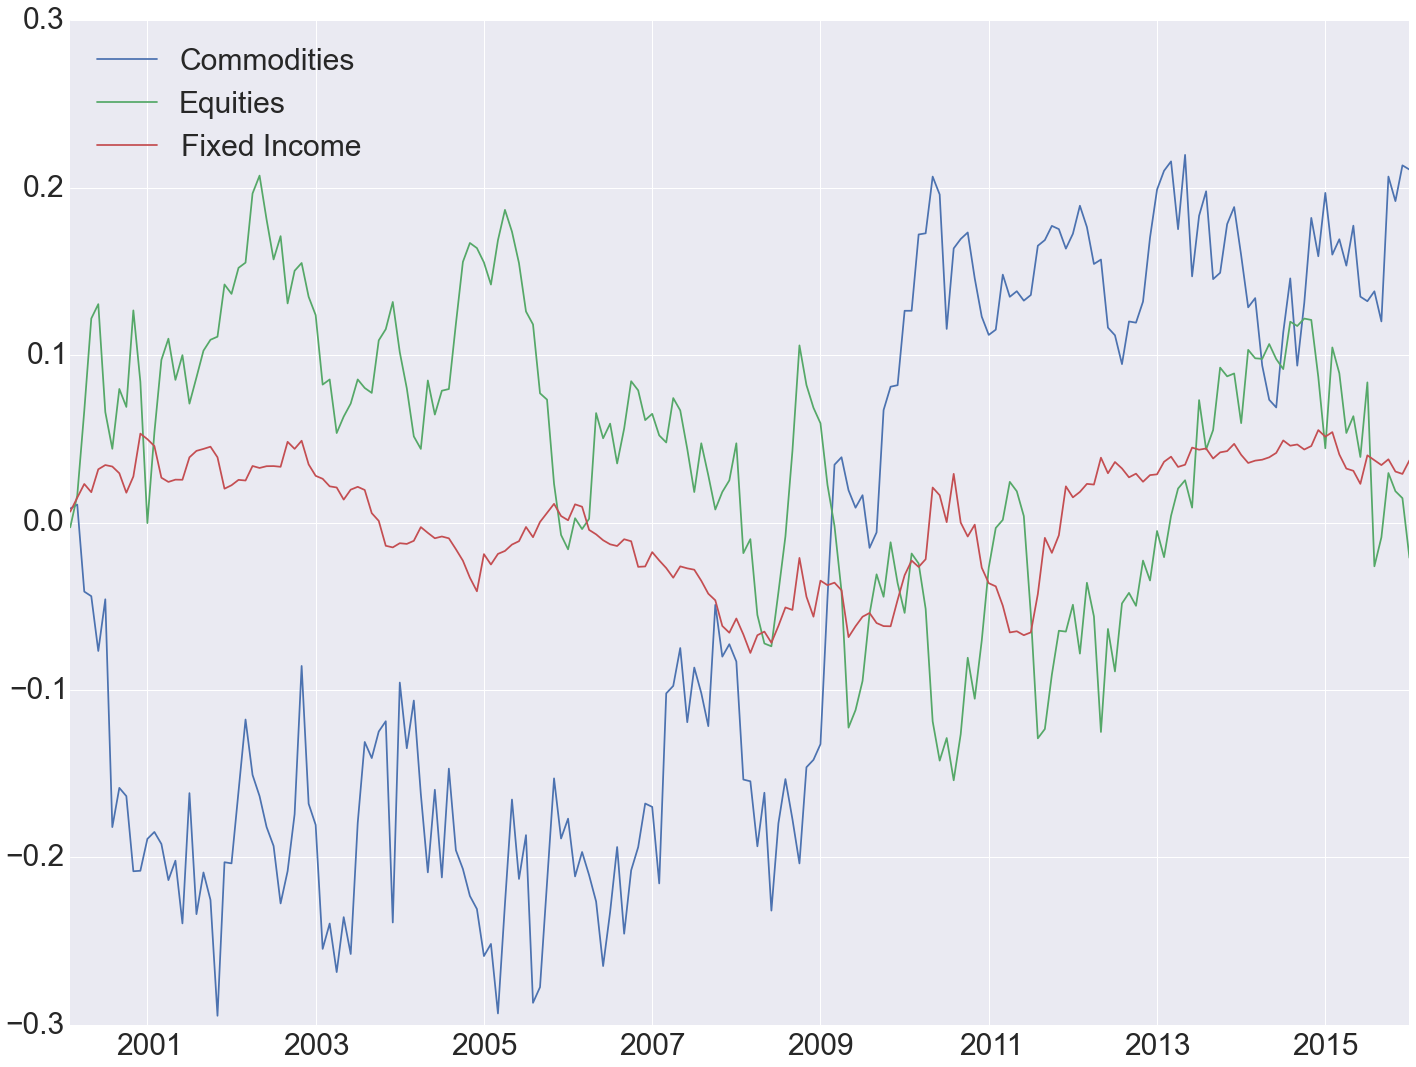

In [45]:
factors_monthly.cumsum().plot()

# Monthly FHT

In [46]:
FHT_monthly = read_monthly(amihud=False)

In [47]:
factors_monthly_FHT=pd.DataFrame()
for s in ['Commodities', 'Equities', 'Fixed Income']:
    factors_monthly_FHT[s]=FHT_monthly[s]['2']-FHT_monthly[s]['0']


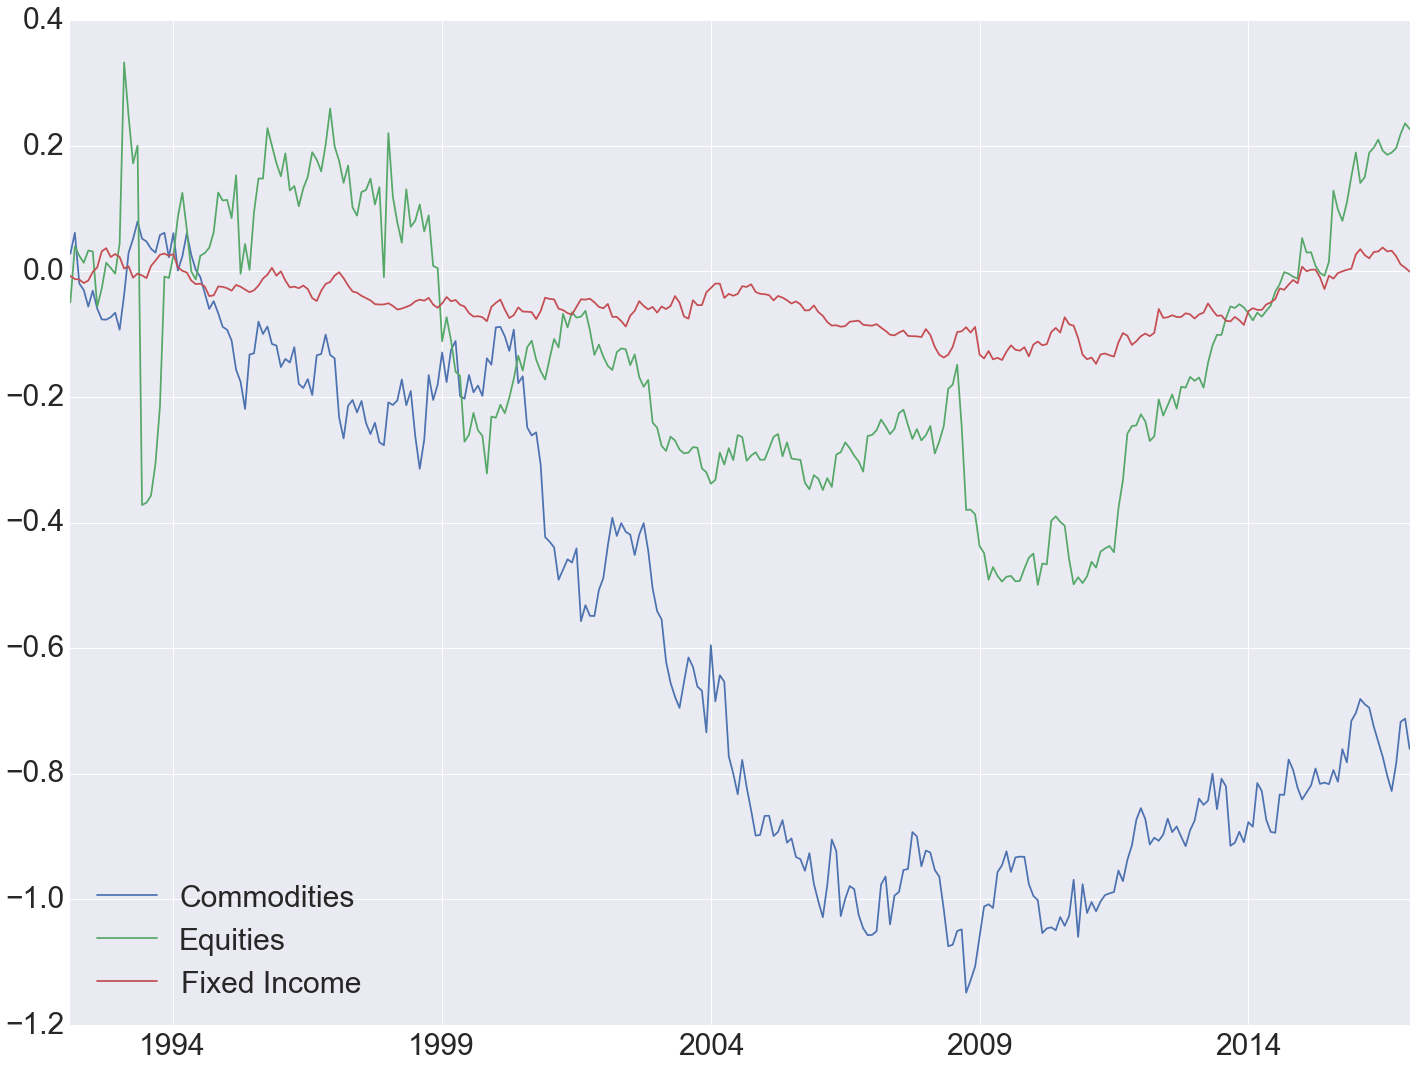

In [48]:
factors_monthly_FHT.cumsum().plot()